In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

from scipy.spatial import distance
import tqdm

In [2]:
import datajoint as dj

In [3]:
schema = dj.schema('photonics')
schema.spawn_missing_classes()

Connecting dimitri@localhost:3306


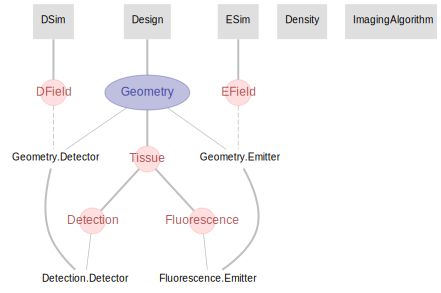

In [4]:
dj.Diagram(schema)

In [5]:
@schema
class Tissue(dj.Computed):
    definition = """
    # Point sources of fluorescence
    -> Geometry
    ---
    volume : float #  (mm^3)
    margin : float # (um) margin to include on boundaries
    npoints : int    # total number of points in volume
    min_distance : float  # (um)
    cell_xyz  : longblob  # cell 
    """
        
    def make(self, key):
        density = 120000
        xyz = np.vstack((
            np.array(
                list(zip(*(Geometry.Detector & key).fetch(
                    'd_center_x', 'd_center_y', 'd_center_z')))),
            np.array(
                list(zip(*(Geometry.Emitter & key).fetch(
                    'e_center_x', 'e_center_y', 'e_center_z'))))))
        margin = 150
        bounds_min = xyz.min(axis=0) - margin
        bounds_max = xyz.max(axis=0) + margin 
        
        volume = (bounds_max - bounds_min).prod()*1e-9
        npoints = int(volume * density)
        
        min_distance = 8.0  
        
        points = np.random.rand(1, 3) * (bounds_max - bounds_min) + bounds_min
        for i in tqdm.tqdm(range(npoints)):
            while True:
                point = np.random.rand(1, 3) * (bounds_max - bounds_min) + bounds_min
                if distance.cdist(points, point).min() > min_distance:
                    break
            points = np.vstack((points, point))

        self.insert1(dict(
            key, volume=volume, margin=margin, 
            npoints=npoints, min_distance=min_distance, cell_xyz=points))


In [ ]:
Tissue.populate()

 46%|████▋     | 94900/204336 [00:42<02:32, 718.85it/s]  

In [ ]:
dj.Diagram(schema)

In [ ]:
@schema
class Fluorescence(dj.Computed):
    definition = """
    -> Tissue
    """
    
    class Emitter(dj.Part):
        definition = """
        # Fluorescence produced by cells per Joule of illumination
        -> master
        -> Geometry.Emitter
        ---
        reemitted_photons  : longblob   # photons emitted from cells per joule of illumination
        photons_per_joule : float  # total photons from all cells
        """
        
    def make(self, key):
        neuron_cross_section = 1e-9  # um^2
        photons_per_joule = 1/(2.8*1.6e-19)   # 2.8 eV blue photons 
        cell_xyz = (Tissue & key).fetch1('cell_xyz')
        self.insert1(key)
        for esim_key in (ESim & (Geometry.Emitter & key)).fetch('KEY'):
            volume, pitch, *dims  = (EField * ESim & esim_key).fetch1(
                'volume', 'pitch', 'volume_dimx', 'volume_dimy', 'volume_dimz')
            dims = np.array(dims)
            for emit_key in tqdm.tqdm((Geometry.Emitter & key & esim_key).fetch('KEY')):
                # cell positions in volume coordinates
                emit = (Geometry.Emitter & emit_key)
                e_xyz = emit.fetch1('e_center_x', 'e_center_y', 'e_center_z')
                z_basis = np.array(emit.fetch1('e_norm_x', 'e_norm_y', 'e_norm_z'))
                y_basis = np.array(emit.fetch1('e_top_x', 'e_top_y', 'e_top_z'))
                x_basis = np.cross(z_basis, y_basis)
                vxyz = np.int16(np.round(
                    (cell_xyz - e_xyz) @ np.vstack((x_basis, y_basis, z_basis)).T / pitch + dims/2))

                # photon counts
                v = neuron_cross_section * photons_per_joule * np.array([
                    volume[q[0], q[1], q[2]] if 
                    0 <= q[0] < dims[0] and 
                    0 <= q[1] < dims[1] and 
                    0 <= q[2] < dims[2] else 0 for q in vxyz])
                self.Emitter.insert1(
                    dict(key, **emit_key, 
                         reemitted_photons = v,
                         photons_per_joule = v.sum()))


In [ ]:
schema.jobs

In [ ]:
@schema
class Detection(dj.Computed):
    definition = """
    -> Tissue
    """
    
    class Detector(dj.Part):
        definition = """
        # Fraction of photons detected from each cell per detector
        -> master
        -> Geometry.Detector
        ---
        detect_probability  : longblob   # fraction of photons detected from each neuron
        mean_probability : longblob  # mean probability of detection across all neurons
        """
        
    def make(self, key):
        cell_xyz = (Tissue & key).fetch1('cell_xyz')
        self.insert1(key)
        for dsim_key in (DSim & (Geometry.Detector & key)).fetch('KEY'):
            volume, pitch, *dims  = (DField * DSim & dsim_key).fetch1(
            'volume', 'pitch', 'volume_dimx', 'volume_dimy', 'volume_dimz')
            dims = np.array(dims)
            for detect_key in tqdm.tqdm((Geometry.Detector & key & dsim_key).fetch('KEY')):
                # cell positions in volume coordinates
                detect = (Geometry.Detector & detect_key)
                d_xyz = detect.fetch1('d_center_x', 'd_center_y', 'd_center_z')
                z_basis = np.array(detect.fetch1('d_norm_x', 'd_norm_y', 'd_norm_z'))
                y_basis = np.array(detect.fetch1('d_top_x', 'd_top_y', 'd_top_z'))
                x_basis = np.cross(z_basis, y_basis)
                vxyz = np.int16(np.round(
                    (cell_xyz - d_xyz) @ np.vstack((x_basis, y_basis, z_basis)).T / pitch + dims/2))
                # photon counts
                v = np.array([
                    volume[q[0], q[1], q[2]] if 
                    0 <= q[0] < dims[0] and 
                    0 <= q[1] < dims[1] and 
                    0 <= q[2] < dims[2] else 0 for q in vxyz])
                self.Detector.insert1(
                    dict(key, **detect_key, 
                         detect_probability = v,
                         total_probability = v.sum()))

In [ ]:
@schema
class Density(dj.Lookup):
    definition = """
    density : int  # cells per cubic mm
    """
    
    contents = zip((1000, 3000, 5000, 10_000, 20_000, 35_000, 50_000, 75_000, 100_000))

In [ ]:
@schema
class ImagingAlgorithm(dj.Lookup):
    definition = """
    imaging_algorithm :  varchar(16)
    """

In [ ]:
@schema
class Imaging(dj.Computed):
    definition = """
    -> Detection
    -> Fluorescence
    -> Density
    -> ImagingAlgorithm
    ---
    """

In [ ]:
@schema
class Mix(dj.Computed):
    definition = """
    -> Imaging
    """

In [ ]:
@schema
class Demix(dj.Computed):
    definition = """
    -> Mix
    """

In [ ]:
Imaging.drop()